# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [ ]:
# import os
# Set GPU device
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [ ]:
!pip install datasets
!pip install evaluate

In [ ]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

('3.4.1', '4.49.0', '2.6.0+cu124')

In [ ]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading our MNLI part of the GLUE dataset

In [ ]:
# # connect with google drive
# from google.colab import drive
# drive.mount('/content/drive')

# # declare file path with os
# import os
# os.chdir('/content/drive/MyDrive/_NLP/A7/NLP-A7-Distillation_vs_LoRA')

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("Hate-speech-CNERG/hatexplain")
print(raw_datasets)

# raw_datasets = load_dataset("tweets-hate-speech-detection/tweets_hate_speech_detection")
# print(raw_datasets)



DatasetDict({
    train: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 1924
    })
})


In [ ]:
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 1924
    })
})


In [ ]:
print(raw_datasets['train'][5])

{'id': '18790322_gab', 'annotators': {'label': [2, 1, 1], 'annotator_id': [203, 202, 204], 'target': [['Hispanic'], ['Hispanic', 'Refugee'], ['Hispanic', 'Refugee']]}, 'rationales': [], 'post_tokens': ['i', 'live', 'and', 'work', 'with', 'many', 'legal', 'mexican', 'immigrants', 'who', 'are', 'great', 'citizens', 'and', 'trump', 'supporters', 'they', 'have', 'no', 'problem', 'with', 'deporting', 'illegals', 'maga']}


In [ ]:
from collections import Counter
print(Counter(raw_datasets['test']['annotators'][0]))  # Try for all entries


Counter({'label': [1, 1, 1], 'annotator_id': [9, 17, 64], 'target': [['None'], ['None'], ['None']]})


In [ ]:
# HateXplain label definitions
label_list = ["hate_speech", "normal", "offensive"]
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}

print(id2label)


{0: 'hate_speech', 1: 'normal', 2: 'offensive'}


## 2. Model & Tokenization

In [ ]:
import numpy as np
# Extract unique labels from "annotators" field
num_labels = np.unique([label for labels in raw_datasets["train"]["annotators"] for label in labels]).size

print("Number of unique labels:", num_labels)

Number of unique labels: 3


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id,
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 3. Preprocessing

In [ ]:
def tokenize_function(examples):
    # Convert tokenized list into full sentences
    text_inputs = [" ".join(tokens) for tokens in examples["post_tokens"]]

    # Tokenize with dynamic padding
    return tokenizer(text_inputs, max_length=128, truncation=True, padding=True)


In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1924
    })
})

In [ ]:
#list data from tokenized
tokenized_datasets['train'][0]['input_ids']

[101,
 1057,
 2428,
 2228,
 1045,
 2052,
 2025,
 2031,
 2042,
 15504,
 2011,
 18993,
 7560,
 2030,
 5152,
 2067,
 1999,
 2634,
 2030,
 7269,
 1998,
 1037,
 9253,
 6394,
 2052,
 9040,
 2033,
 2004,
 2092,
 2074,
 2000,
 2156,
 2033,
 5390,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
from collections import Counter

def convert_labels(example):
    batch_labels = []

    for annotators in example["annotators"]:  # Each annotator entry (dict)
        labels = annotators.get("label", [])

        # Keep only valid integer labels
        valid_labels = [int(l) for l in labels if isinstance(l, (int, float, str)) and str(l).isdigit()]

        # Majority vote or fallback
        if valid_labels:
            most_common = Counter(valid_labels).most_common(1)[0][0]
        else:
            most_common = 1  # Default to 'normal' if no valid label

        batch_labels.append(most_common)

    return {"labels": batch_labels}


In [ ]:
tokenized_datasets_with_labels = tokenized_datasets.map(convert_labels, batched=True)

# Drop old 'annotators' field
tokenized_datasets_with_labels = tokenized_datasets_with_labels.remove_columns(["annotators"])

# Final dataset with labels
tokenized_datasets = tokenized_datasets_with_labels


Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
print(np.unique(tokenized_datasets['test']['labels'], return_counts=True))

(array([0, 1, 2]), array([594, 782, 548]))


In [ ]:
import numpy as np
print(np.unique(tokenized_datasets['validation']['labels'], return_counts=True))

(array([0, 1, 2]), array([593, 781, 548]))


In [ ]:
import numpy as np
print(np.unique(tokenized_datasets['train']['labels'], return_counts=True))

(array([0, 1, 2]), array([4748, 6251, 4384]))


In [ ]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'rationales', 'post_tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['id', 'rationales', 'post_tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['id', 'rationales', 'post_tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1924
    })
})


In [ ]:
tokenized_datasets['train'][0]

{'id': '23107796_gab',
 'rationales': [[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]],
 'post_tokens': ['u',
  'really',
  'think',
  'i',
  'would',
  'not',
  'have',
  'been',
  'raped',
  'by',
  'feral',
  'hindu',
  'or',
  'muslim',
  'back',
  'in',
  'india',
  'or',
  'bangladesh',
  'and',
  'a',
  'neo',
  'nazi',
  'would',
  'rape',
  'me',
  'as',
  'well',
  'just',
  'to',
  'see',
  'me',
  'cry'],
 'input_ids': [101,
  1057,
  2428,
  2228,
  1045,
  2052,
  2025,
  2031,
  2042,
  15504,
  2011,
  18993,
  7560,
  2030,
  5152,
  2067,
  1999,
  2634,
  2030,
  7269,
  1998,
  1037,
  9253,
  6394,
  2052,
  9040,
  2033,
 

In [ ]:
print(tokenizer.pad_token_id)  # Typically returns 0
print(tokenizer.pad_token)  # Typically returns [PAD]


0
[PAD]


In [ ]:
non_padded_tokens = [token for token in tokenized_datasets['train'][0]['input_ids'] if token != tokenizer.pad_token_id]
print(non_padded_tokens)


[101, 1057, 2428, 2228, 1045, 2052, 2025, 2031, 2042, 15504, 2011, 18993, 7560, 2030, 5152, 2067, 1999, 2634, 2030, 7269, 1998, 1037, 9253, 6394, 2052, 9040, 2033, 2004, 2092, 2074, 2000, 2156, 2033, 5390, 102]


In [ ]:
decoded_text = tokenizer.decode(non_padded_tokens)
print(decoded_text)


[CLS] u really think i would not have been raped by feral hindu or muslim back in india or bangladesh and a neo nazi would rape me as well just to see me cry [SEP]


In [ ]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] u really think i would not have been raped by feral hindu or muslim back in india or bangladesh and a neo nazi would rape me as well just to see me cry [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'





## 4. Preparing the dataloader

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(['id','rationales','post_tokens'])

In [ ]:
tokenized_datasets.set_format("torch")

In [ ]:
tokenized_datasets['train']

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 15383
})

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], batch_size=8, shuffle=True, collate_fn=data_collator
)


In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(1000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=1150).select(range(100))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(100))

In [ ]:
#from torch.utils.data import DataLoader

# train_dataloader = DataLoader(
#     small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
# test_dataloader = DataLoader(
#     small_test_dataset, batch_size=32, collate_fn=data_collator)
# eval_dataloader = DataLoader(
#     small_eval_dataset, batch_size=32, collate_fn=data_collator)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], batch_size=8, shuffle=True, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, shuffle=False, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=8, shuffle=False, collate_fn=data_collator
)


In [ ]:
for batch in train_dataloader:
    break

print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["labels"].shape)


torch.Size([8, 110]) torch.Size([8, 110]) torch.Size([8])


In [ ]:
for batch in train_dataloader:
    print(batch.keys())  # Ensure it includes 'input_ids', 'attention_mask', 'labels'
    print(batch["input_ids"].shape)
    print(batch["attention_mask"].shape)
    print(batch["labels"].shape)
    break


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])


In [ ]:
for batch in train_dataloader:
    break

print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["labels"].shape)


torch.Size([8, 95]) torch.Size([8, 95]) torch.Size([8])


## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture
In the present work, the student - DistilBERT - has the same general architecture as BERT.
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2.
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers.
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher).
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [ ]:
teacher_model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "hate_speech",
    "1": "normal",
    "2": "offensive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "hate_speech": 0,
    "normal": 1,
    "offensive": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

####
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [ ]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [ ]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [ ]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [ ]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher: Module,
    student: Module,
    use_odd_layers: bool = True  # Flag to select odd or even layers
) -> None:
    """
    Copies weights from the teacher model to the student model.
    - If `use_odd_layers=True`, copies odd-numbered layers {1, 3, 5, 7, 9, 11}.
    - If `use_odd_layers=False`, copies even-numbered layers {2, 4, 6, 8, 10, 12}.
    """
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, use_odd_layers)

    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())]  # 12 layers
        student_encoding_layers = [layer for layer in next(student.children())]  # 6 layers

        #  Select Odd or Even Layers
        selected_layers = range(1, 12, 2) if use_odd_layers else range(0, 12, 2)

        for i, layer_idx in enumerate(selected_layers):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[layer_idx].state_dict())

    else:
        student.load_state_dict(teacher.state_dict())

    return student  # Fix: Return the student model after weight copying


In [ ]:
# model = distill_bert_weights(teacher=teacher_model, student=model)

In [ ]:
student_model_odd = distill_bert_weights(teacher=teacher_model, student=model, use_odd_layers=True)
student_model_even = distill_bert_weights(teacher=teacher_model, student=model, use_odd_layers=False)

In [ ]:
def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(student_model_odd))

Teacher parameters : 109484547
Student parameters : 66957315


In [ ]:
def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(student_model_even))

Teacher parameters : 109484547
Student parameters : 66957315


In [ ]:
count_parameters(model)/count_parameters(teacher_model) * 100

61.15686353435797

In [ ]:
# Move models to the available device
student_model_odd.to(device)
student_model_even.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [ ]:
#It has 40% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [ ]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities!
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits
        '''
        T = temperature #.cuda()

        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T

        return KD_loss

In [ ]:
# Loss functions
criterion_cls = nn.CrossEntropyLoss()  # Classification Loss
criterion_div = DistillKL()  # KL Divergence Loss
criterion_cos = nn.CosineEmbeddingLoss()  # Cosine Similarity Loss

## 6. Optimizer

In [ ]:
import torch.optim as optim
import torch.nn as nn

# Optimizers
lr = 5e-5
optimizer_odd = optim.Adam(params=student_model_odd.parameters(), lr=lr)
optimizer_even = optim.Adam(params=student_model_even.parameters(), lr=lr)

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

## 7. Learning rate scheduler

In [ ]:
# Learning rate schedulers
from transformers import get_scheduler

lr_scheduler_odd = get_scheduler(
    name="linear", optimizer=optimizer_odd, num_warmup_steps=0, num_training_steps=num_training_steps
)
lr_scheduler_even = get_scheduler(
    name="linear", optimizer=optimizer_even, num_warmup_steps=0, num_training_steps=num_training_steps
)

## 8. Metric

In [ ]:
# Metric for
import evaluate

metric = evaluate.load("accuracy")

## 9. Train

In [ ]:
# ### working code


# import numpy as np
# import evaluate
# import torch
# from tqdm.auto import tqdm
# from transformers import AdamW, TrainerCallback


# # ✅ Use appropriate evaluation metric for HateXplain (F1-score recommended)
# accuracy_metric = evaluate.load("accuracy")
# precision_metric = evaluate.load("precision")
# recall_metric = evaluate.load("recall")
# f1_metric = evaluate.load("f1")

# # ✅ Function to compute multiple metrics
# def compute_multiple_metrics(predictions, labels):
#     return {
#         "accuracy": accuracy_metric.compute(predictions=predictions, references=labels),
#         "precision": precision_metric.compute(predictions=predictions, references=labels, average="macro"),
#         "recall": recall_metric.compute(predictions=predictions, references=labels, average="macro"),
#         "f1": f1_metric.compute(predictions=predictions, references=labels, average="macro"),
#     }

# # ✅ Early Stopping Callback
# class EarlyStoppingCallback(TrainerCallback):
#     def __init__(self, patience=2):
#         self.patience = patience
#         self.best_loss = float("inf")
#         self.counter = 0

#     def on_evaluate(self, args, state, control, logs=None, **kwargs):
#         if logs["eval_loss"] < self.best_loss:
#             self.best_loss = logs["eval_loss"]
#             self.counter = 0
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 control.should_training_stop = True

# # ✅ Reduce Learning Rate & Add Weight Decay for Regularization
# optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)  # Lower LR, add weight decay

# # ✅ Increase Number of Training Steps if Needed
# #num_epochs = 10  # Increase from 5 to 10+
# progress_bar = tqdm(range(num_training_steps))
# eval_metrics = { "accuracy": 0, "precision": 0, "recall": 0, "f1": 0 }

# # ✅ Lists to store losses for each epoch
# train_losses, train_losses_cls, train_losses_div, train_losses_cos, eval_losses = [], [], [], [], []

# for epoch in range(num_epochs):
#     model.train()
#     teacher_model.eval()
#     train_loss, train_loss_cls, train_loss_div, train_loss_cos = 0, 0, 0, 0

#     # ✅ Training Loop
#     for batch in train_dataloader:
#         batch = {k: v.to(device) for k, v in batch.items()}

#         # Compute student output
#         outputs = model(**batch)

#         # Compute teacher output (no gradient updates)
#         with torch.no_grad():
#             output_teacher = teacher_model(**batch)

#         # Ensure logits match
#         assert outputs.logits.size() == output_teacher.logits.size()

#         # Compute classification loss
#         loss_cls = outputs.loss
#         train_loss_cls += loss_cls.item()

#         # Compute distillation loss
#         loss_div = criterion_div(outputs.logits, output_teacher.logits)
#         train_loss_div += loss_div.item()

#         # Compute cosine similarity loss
#         loss_cos = criterion_cos(
#             output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device)
#         )
#         train_loss_cos += loss_cos.item()

#         # ✅ Adjust Distillation Loss Scaling
#         loss = (0.2 * loss_cls + 0.5 * loss_div + 0.3 * loss_cos)  # Less CLS loss, more DIV loss

#         train_loss += loss.item()

#         # Backpropagation
#         loss.backward()
#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

#     # ✅ Store losses for visualization
#     train_losses.append(train_loss / len(train_dataloader))
#     train_losses_cls.append(train_loss_cls / len(train_dataloader))
#     train_losses_div.append(train_loss_div / len(train_dataloader))
#     train_losses_cos.append(train_loss_cos / len(train_dataloader))

#     # ✅ Print training loss details
#     print(f'\nEpoch {epoch+1}/{num_epochs}')
#     print(f'  Train Loss: {train_loss/len(train_dataloader):.4f}')
#     print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
#     print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
#     print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')

#     # ✅ Evaluation Loop
#     model.eval()
#     eval_loss = 0
#     all_predictions, all_labels = [], []

#     for batch in eval_dataloader:
#         batch = {k: v.to(device) for k, v in batch.items()}

#         with torch.no_grad():
#             outputs = model(**batch)

#         loss_cls = outputs.loss
#         eval_loss += loss_cls.item()

#         # Get predictions and labels
#         predictions = outputs.logits.argmax(dim=-1).cpu().numpy()
#         labels = batch["labels"].cpu().numpy()

#         # Store predictions for metric computation
#         all_predictions.extend(predictions)
#         all_labels.extend(labels)

#     # ✅ Compute evaluation metrics
#     eval_metric = compute_multiple_metrics(np.array(all_predictions), np.array(all_labels))
#     eval_losses.append(eval_loss / len(eval_dataloader))

#     # ✅ Print evaluation results
#     # print(eval_metric)
#     print(f'  Eval Loss: {eval_loss/len(eval_dataloader):.4f}')
#     print(f'  Eval Metrics: '
#       f'Acc={eval_metric["accuracy"]["accuracy"]:.4f}, '
#       f'Prec={eval_metric["precision"]["precision"]:.4f}, '
#       f'Rec={eval_metric["recall"]["recall"]:.4f}, '
#       f'F1={eval_metric["f1"]["f1"]:.4f}')

# # ✅ Print Final Average Metrics
# avg_metrics = {key: val / num_epochs for key, val in eval_metrics.items()}
# print("\nFinal Average Metrics:")
# print(f'  Accuracy: {avg_metrics["accuracy"]:.4f}')
# print(f'  Precision: {avg_metrics["precision"]:.4f}')
# print(f'  Recall: {avg_metrics["recall"]:.4f}')
# print(f'  F1-score: {avg_metrics["f1"]:.4f}')


In [ ]:
# import numpy as np
# import evaluate
# import torch
# from tqdm.auto import tqdm
# from transformers import AdamW, TrainerCallback, get_scheduler, AutoModelForSequenceClassification

# # ✅ Use appropriate evaluation metric for HateXplain (F1-score recommended)

# accuracy_metric = evaluate.load("accuracy")
# precision_metric = evaluate.load("precision")
# recall_metric = evaluate.load("recall")
# f1_metric = evaluate.load("f1")

# # ✅ Load teacher and initialize student models
# teacher_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
# student_model_odd = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels, num_hidden_layers=6)  # ✅
# student_model_even = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels, num_hidden_layers=6)  # ✅

# # ✅ Distill weights from teacher to student models
# student_model_odd = distill_bert_weights(teacher_model, student_model_odd, use_odd_layers=True)
# student_model_even = distill_bert_weights(teacher_model, student_model_even, use_odd_layers=False)

# # ✅ Function to compute multiple metrics
# def compute_multiple_metrics(predictions, labels):
#     return {
#         "accuracy": accuracy_metric.compute(predictions=predictions, references=labels),
#         "precision": precision_metric.compute(predictions=predictions, references=labels, average="macro"),
#         "recall": recall_metric.compute(predictions=predictions, references=labels, average="macro"),
#         "f1": f1_metric.compute(predictions=predictions, references=labels, average="macro"),
#     }

# # ✅ Function to train a given student model
# def train_student_model(student_model, model_name):
#     print(f"\n🔹 Training {model_name}...\n")

#     # ✅ Move models to the appropriate device
#     student_model.to(device)
#     teacher_model.to(device)

#     # ✅ Define optimizer & scheduler
#     optimizer = AdamW(student_model.parameters(), lr=2e-5, weight_decay=0.01)

#     num_update_steps_per_epoch = len(train_dataloader)
#     num_training_steps = num_epochs * num_update_steps_per_epoch
#     num_warmup_steps = int(0.1 * num_training_steps)  # 10% warm-up

#     lr_scheduler = get_scheduler(
#         name="linear",
#         optimizer=optimizer,
#         num_warmup_steps=num_warmup_steps,
#         num_training_steps=num_training_steps
#     )

#     # ✅ Move loss functions to the appropriate device (if they are not already there)
#     criterion_div.to(device)
#     criterion_cos.to(device)

#     # ✅ Training Loop
#     progress_bar = tqdm(range(num_training_steps))
#     eval_metrics = { "accuracy": 0, "precision": 0, "recall": 0, "f1": 0 }

#     train_losses, eval_losses = [], []

#     for epoch in range(num_epochs):
#         student_model.train()
#         teacher_model.eval()
#         train_loss = 0

#         for batch in train_dataloader:
#             batch = {k: v.to(device) for k, v in batch.items()}

#             # Compute student output
#             outputs = student_model(**batch)

#             # Compute teacher output (no gradient updates)
#             with torch.no_grad():
#                 output_teacher = teacher_model(**batch)

#             # Compute classification loss
#             loss_cls = outputs.loss

#             # Compute distillation loss
#             loss_div = criterion_div(outputs.logits, output_teacher.logits)

#             # Compute cosine similarity loss
#             loss_cos = criterion_cos(
#                 output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device)
#             )

#             # Adjust Distillation Loss Scaling
#             loss = (0.2 * loss_cls + 0.5 * loss_div + 0.3 * loss_cos)

#             train_loss += loss.item()

#             # Backpropagation
#             loss.backward()
#             optimizer.step()
#             lr_scheduler.step()
#             optimizer.zero_grad()
#             progress_bar.update(1)

#         train_losses.append(train_loss / len(train_dataloader))

#         # ✅ Evaluation Loop
#         student_model.eval()
#         eval_loss = 0
#         all_predictions, all_labels = [], []

#         for batch in eval_dataloader:
#             batch = {k: v.to(device) for k, v in batch.items()}

#             with torch.no_grad():
#                 outputs = student_model(**batch)

#             loss_cls = outputs.loss
#             eval_loss += loss_cls.item()

#             predictions = outputs.logits.argmax(dim=-1).cpu().numpy()
#             labels = batch["labels"].cpu().numpy()

#             all_predictions.extend(predictions)
#             all_labels.extend(labels)

#         eval_metric = compute_multiple_metrics(np.array(all_predictions), np.array(all_labels))
#         eval_losses.append(eval_loss / len(eval_dataloader))

#         # ✅ Print evaluation results
#         print(f'\nEpoch {epoch+1}/{num_epochs} - {model_name}')
#         print(f'  Train Loss: {train_loss/len(train_dataloader):.4f}')
#         print(f'  Eval Loss: {eval_loss/len(eval_dataloader):.4f}')
#         print(f'  Eval Metrics: '
#               f'Acc={eval_metric["accuracy"]["accuracy"]:.4f}, '
#               f'Prec={eval_metric["precision"]["precision"]:.4f}, '
#               f'Rec={eval_metric["recall"]["recall"]:.4f}, '
#               f'F1={eval_metric["f1"]["f1"]:.4f}')

#     return train_losses, eval_losses, eval_metric

# # ✅ Train both models
# train_losses_odd, eval_losses_odd, eval_metric_odd = train_student_model(student_model_odd, "student_model_odd")
# train_losses_even, eval_losses_even, eval_metric_even = train_student_model(student_model_even, "student_model_even")

# # ✅ Compare Results
# print("\n🔹 Final Evaluation Comparison:")
# print(f"\n🔹 Student Model (Odd Layers):")
# print(f'  Accuracy: {eval_metric_odd["accuracy"]["accuracy"]:.4f}')
# print(f'  Precision: {eval_metric_odd["precision"]["precision"]:.4f}')
# print(f'  Recall: {eval_metric_odd["recall"]["recall"]:.4f}')
# print(f'  F1-score: {eval_metric_odd["f1"]["f1"]:.4f}')

# print(f"\n🔹 Student Model (Even Layers):")
# print(f'  Accuracy: {eval_metric_even["accuracy"]["accuracy"]:.4f}')
# print(f'  Precision: {eval_metric_even["precision"]["precision"]:.4f}')
# print(f'  Recall: {eval_metric_even["recall"]["recall"]:.4f}')
# print(f'  F1-score: {eval_metric_even["f1"]["f1"]:.4f}')

In [ ]:
### working

# def train_student_model(student_model, optimizer, lr_scheduler, student_type="odd"):
#     """
#     Trains the student model (Odd or Even) and evaluates it.
#     """
#     progress_bar = tqdm(range(num_training_steps))
#     eval_metrics = 0

#     # Lists to store losses for each epoch
#     train_losses = []
#     train_losses_cls = []
#     train_losses_div = []
#     train_losses_cos = []
#     eval_losses = []

#     for epoch in range(num_epochs):
#         student_model.train()
#         teacher_model.eval()
#         train_loss = 0
#         train_loss_cls = 0
#         train_loss_div = 0
#         train_loss_cos = 0

#         for batch in train_dataloader:
#             batch = {k: v.to(device) for k, v in batch.items()}
#             outputs = student_model(**batch)  # Student model predictions

#             with torch.no_grad():
#                 output_teacher = teacher_model(**batch)  # Teacher model predictions

#             # Compute Losses
#             loss_cls  = criterion_cls(outputs.logits, batch["labels"])  # Classification loss
#             loss_div = criterion_div(outputs.logits, output_teacher.logits)  # KL Divergence
#             loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))  # Cosine similarity loss

#             # Weighted total loss
#             loss = (loss_cls + loss_div + loss_cos) / 3

#             # Store loss values
#             train_loss += loss.item()
#             train_loss_cls += loss_cls.item()
#             train_loss_div += loss_div.item()
#             train_loss_cos += loss_cos.item()

#             # Backpropagation
#             loss.backward()
#             optimizer.step()
#             lr_scheduler.step()
#             optimizer.zero_grad()
#             progress_bar.update(1)

#         train_losses.append(train_loss / len(train_dataloader))
#         train_losses_cls.append(train_loss_cls / len(train_dataloader))
#         train_losses_div.append(train_loss_div / len(train_dataloader))
#         train_losses_cos.append(train_loss_cos / len(train_dataloader))

#         print(f'Epoch {epoch+1} ({student_type} student): Train Loss: {train_loss/len(train_dataloader):.4f}')
#         print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
#         print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
#         print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')

#         # Evaluate model
#         student_model.eval()
#         eval_loss = 0

#         for batch in eval_dataloader:
#             batch = {k: v.to(device) for k, v in batch.items()}
#             with torch.no_grad():
#                 outputs = student_model(**batch)

#             loss_cls = criterion_cls(outputs.logits, batch["labels"])
#             predictions = outputs.logits.argmax(dim=-1)

#             eval_loss += loss_cls.item()
#             metric.add_batch(predictions=predictions, references=batch["labels"])

#         eval_metric = metric.compute()
#         eval_metrics += eval_metric["accuracy"]
#         eval_losses.append(eval_loss / len(eval_dataloader))

#         print(f"Epoch {epoch+1} ({student_type} student): Test Accuracy: {eval_metric['accuracy']:.4f}")

#     print(f'Average Accuracy ({student_type} student): {eval_metrics/num_epochs:.4f}')

In [ ]:
import numpy as np
from tqdm.auto import tqdm
import torch
import evaluate

# Load evaluation metrics once
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(preds, labels):
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall": recall_metric.compute(predictions=preds, references=labels, average="macro")["recall"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

def train_student_model(student_model, optimizer, lr_scheduler, student_type="odd"):
    print(f"\n🔹 Starting training for {student_type} student model...\n")

    progress_bar = tqdm(range(num_training_steps))
    student_model.to(device)
    teacher_model.to(device)

    # Store loss and metric history
    train_losses, train_cls, train_div, train_cos = [], [], [], []
    eval_losses, eval_metrics_list = [], []

    # Track average metrics across epochs
    avg_metrics = {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0}

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()

        total_loss, loss_cls_total, loss_div_total, loss_cos_total = 0, 0, 0, 0

        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs_student = student_model(**batch)
            with torch.no_grad():
                outputs_teacher = teacher_model(**batch)

            # Losses
            loss_cls = criterion_cls(outputs_student.logits, batch["labels"])
            loss_div = criterion_div(outputs_student.logits, outputs_teacher.logits)
            loss_cos = criterion_cos(outputs_teacher.logits, outputs_student.logits,
                                     torch.ones(outputs_teacher.logits.size(0)).to(device))

            # Total loss (weighted avg)
            loss = (loss_cls + loss_div + loss_cos) / 3

            # Backprop
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Accumulate losses
            total_loss += loss.item()
            loss_cls_total += loss_cls.item()
            loss_div_total += loss_div.item()
            loss_cos_total += loss_cos.item()

            progress_bar.update(1)

        # Store training losses
        train_losses.append(total_loss / len(train_dataloader))
        train_cls.append(loss_cls_total / len(train_dataloader))
        train_div.append(loss_div_total / len(train_dataloader))
        train_cos.append(loss_cos_total / len(train_dataloader))

        # Evaluation
        student_model.eval()
        eval_loss, all_preds, all_labels = 0, [], []

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = student_model(**batch)
                loss_eval = criterion_cls(outputs.logits, batch["labels"])
                preds = outputs.logits.argmax(dim=-1)

            eval_loss += loss_eval.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

        # Compute metrics
        metrics = compute_metrics(np.array(all_preds), np.array(all_labels))
        for key in avg_metrics:
            avg_metrics[key] += metrics[key]

        eval_losses.append(eval_loss / len(eval_dataloader))
        eval_metrics_list.append(metrics)

        # Logging
        print(f"\n📘 Epoch {epoch+1}/{num_epochs} — {student_type} student")
        print(f"  🔹 Train Loss:     {train_losses[-1]:.4f}")
        print(f"     - CLS: {train_cls[-1]:.4f}, DIV: {train_div[-1]:.4f}, COS: {train_cos[-1]:.4f}")
        print(f"  🔸 Eval Loss:      {eval_losses[-1]:.4f}")
        print(f"  🔸 Eval Metrics:   Acc={metrics['accuracy']:.4f}, Prec={metrics['precision']:.4f}, "
              f"Rec={metrics['recall']:.4f}, F1={metrics['f1']:.4f}")

    # Print average metrics
    print(f"\n📊 Average Metrics for {student_type} student over {num_epochs} epochs:")
    for key in avg_metrics:
        print(f"  {key.capitalize()}: {avg_metrics[key]/num_epochs:.4f}")

    # Return results for plotting or further analysis
    return {
        "train_losses": train_losses,
        "train_cls": train_cls,
        "train_div": train_div,
        "train_cos": train_cos,
        "eval_losses": eval_losses,
        "metrics_per_epoch": eval_metrics_list,
        "final_avg_metrics": {k: avg_metrics[k]/num_epochs for k in avg_metrics}
    }


In [ ]:
# Train Odd-Layer Student Model
print("\n=== Training Odd-Layer Student Model ===")
odd_result = train_student_model(student_model_odd, optimizer_odd, lr_scheduler_odd, "odd")

# Train Even-Layer Student Model
print("\n=== Training Even-Layer Student Model ===")
even_result = train_student_model(student_model_even, optimizer_even, lr_scheduler_even, "even")




=== Training Odd-Layer Student Model ===

🔹 Starting training for odd student model...



  0%|          | 0/9615 [00:00<?, ?it/s]


📘 Epoch 1/5 — odd student
  🔹 Train Loss:     0.3561
     - CLS: 0.8927, DIV: 0.0762, COS: 0.0995
  🔸 Eval Loss:      0.8258
  🔸 Eval Metrics:   Acc=0.6826, Prec=0.6747, Rec=0.6687, F1=0.6706

📘 Epoch 2/5 — odd student
  🔹 Train Loss:     0.3264
     - CLS: 0.7773, DIV: 0.1120, COS: 0.0899
  🔸 Eval Loss:      0.8323
  🔸 Eval Metrics:   Acc=0.6769, Prec=0.6736, Rec=0.6765, F1=0.6734

📘 Epoch 3/5 — odd student
  🔹 Train Loss:     0.2957
     - CLS: 0.6453, DIV: 0.1541, COS: 0.0879
  🔸 Eval Loss:      0.8215
  🔸 Eval Metrics:   Acc=0.6748, Prec=0.6805, Rec=0.6660, F1=0.6710

📘 Epoch 4/5 — odd student
  🔹 Train Loss:     0.2716
     - CLS: 0.5401, DIV: 0.1878, COS: 0.0869
  🔸 Eval Loss:      0.8159
  🔸 Eval Metrics:   Acc=0.6733, Prec=0.6656, Rec=0.6667, F1=0.6661

📘 Epoch 5/5 — odd student
  🔹 Train Loss:     0.2599
     - CLS: 0.4911, DIV: 0.2033, COS: 0.0852
  🔸 Eval Loss:      0.8244
  🔸 Eval Metrics:   Acc=0.6644, Prec=0.6614, Rec=0.6592, F1=0.6599

📊 Average Metrics for odd student 

  0%|          | 0/9615 [00:00<?, ?it/s]


📘 Epoch 1/5 — even student
  🔹 Train Loss:     0.2740
     - CLS: 0.5448, DIV: 0.1903, COS: 0.0867
  🔸 Eval Loss:      0.8412
  🔸 Eval Metrics:   Acc=0.6675, Prec=0.6610, Rec=0.6593, F1=0.6601

📘 Epoch 2/5 — even student
  🔹 Train Loss:     0.2640
     - CLS: 0.5072, DIV: 0.2007, COS: 0.0841
  🔸 Eval Loss:      0.8551
  🔸 Eval Metrics:   Acc=0.6550, Prec=0.6677, Rec=0.6502, F1=0.6546

📘 Epoch 3/5 — even student
  🔹 Train Loss:     0.2558
     - CLS: 0.4764, DIV: 0.2098, COS: 0.0811
  🔸 Eval Loss:      0.8551
  🔸 Eval Metrics:   Acc=0.6566, Prec=0.6638, Rec=0.6522, F1=0.6551

📘 Epoch 4/5 — even student
  🔹 Train Loss:     0.2495
     - CLS: 0.4526, DIV: 0.2167, COS: 0.0792
  🔸 Eval Loss:      0.8396
  🔸 Eval Metrics:   Acc=0.6597, Prec=0.6504, Rec=0.6530, F1=0.6515

📘 Epoch 5/5 — even student
  🔹 Train Loss:     0.2462
     - CLS: 0.4409, DIV: 0.2201, COS: 0.0776
  🔸 Eval Loss:      0.8441
  🔸 Eval Metrics:   Acc=0.6545, Prec=0.6474, Rec=0.6483, F1=0.6477

📊 Average Metrics for even st

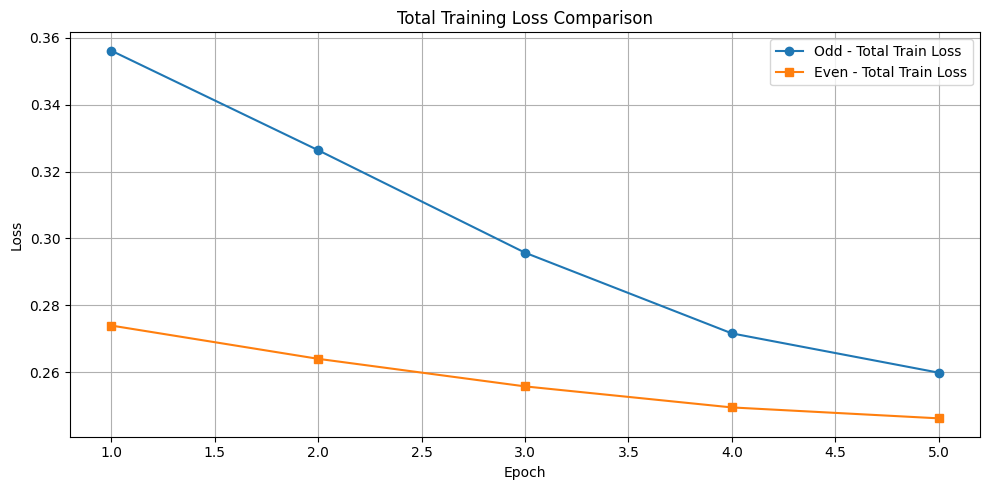

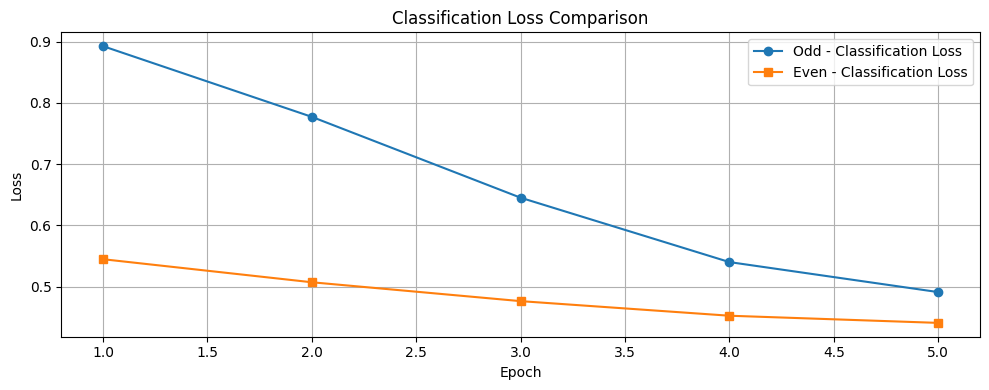

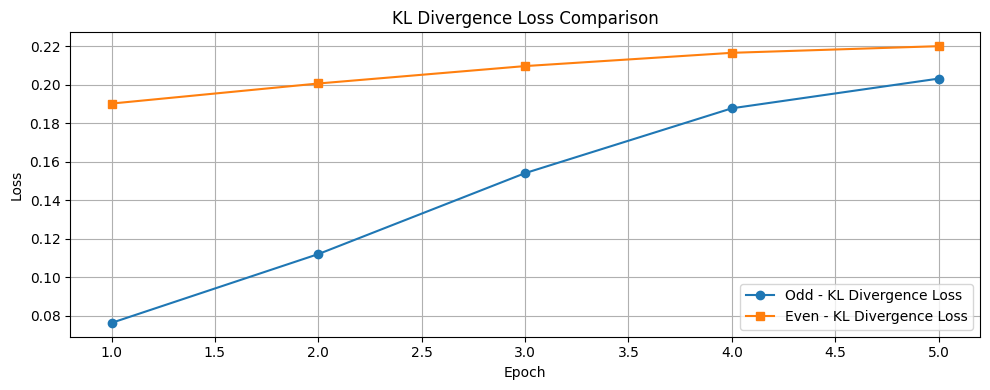

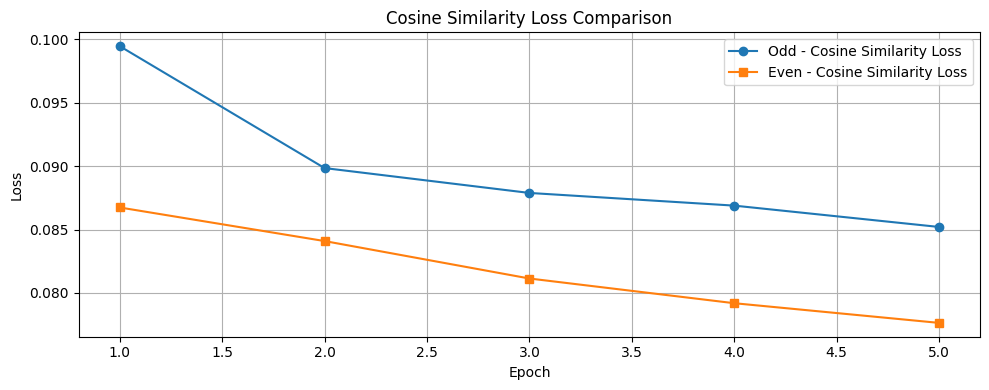

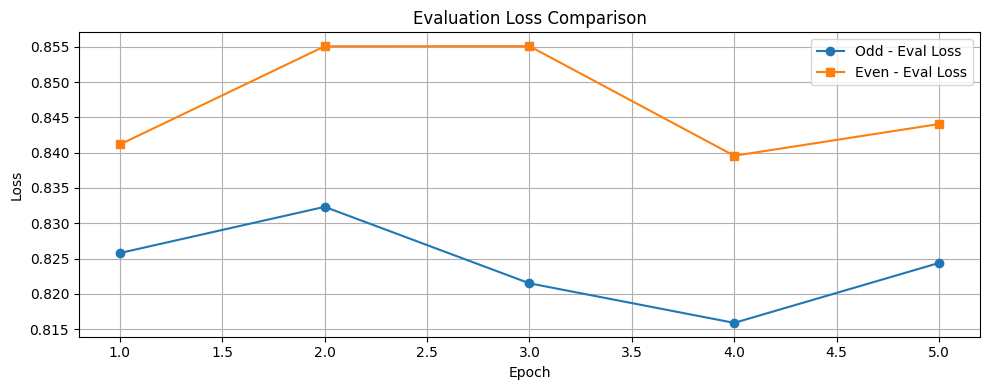

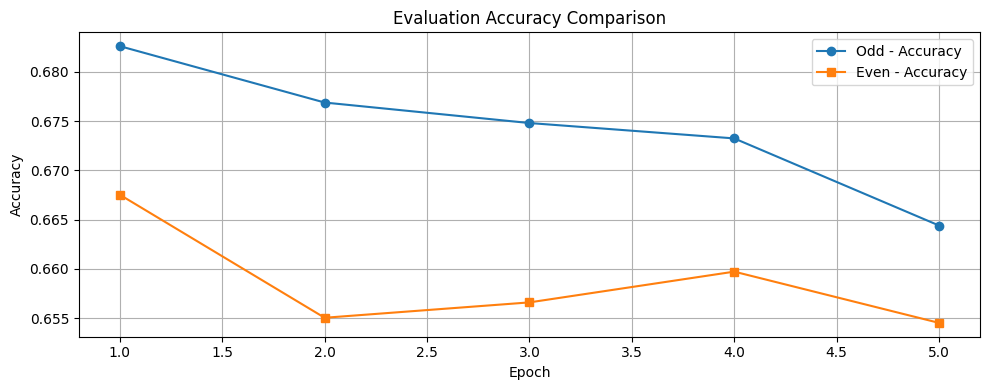

In [ ]:
import matplotlib.pyplot as plt

# Example: extract from results
epochs = list(range(1, len(odd_result['train_losses']) + 1))

# Training Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, odd_result['train_losses'], label="Odd - Total Train Loss", marker="o")
plt.plot(epochs, even_result['train_losses'], label="Even - Total Train Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Total Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Individual Losses (CLS, DIV, COS)
loss_types = ['train_cls', 'train_div', 'train_cos']
loss_labels = ['Classification Loss', 'KL Divergence Loss', 'Cosine Similarity Loss']

for loss_key, label in zip(loss_types, loss_labels):
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, odd_result[loss_key], label=f"Odd - {label}", marker="o")
    plt.plot(epochs, even_result[loss_key], label=f"Even - {label}", marker="s")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{label} Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Evaluation Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_result['eval_losses'], label="Odd - Eval Loss", marker="o")
plt.plot(epochs, even_result['eval_losses'], label="Even - Eval Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evaluation Loss Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy
odd_acc = [m['accuracy'] for m in odd_result['metrics_per_epoch']]
even_acc = [m['accuracy'] for m in even_result['metrics_per_epoch']]

plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_acc, label="Odd - Accuracy", marker="o")
plt.plot(epochs, even_acc, label="Even - Accuracy", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Compare LORA with Student Model

In [ ]:
# Prepare 12-layer BERT Student Model
from transformers import AutoModelForSequenceClassification

student_model_lora = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Apply LoRA Using PEFT
from peft import get_peft_model, LoraConfig, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,           # Rank
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)

student_model_lora = get_peft_model(student_model_lora, lora_config)
student_model_lora.print_trainable_parameters()  # Optional: to confirm only LoRA layers are trainable

trainable params: 297,219 || all params: 109,781,766 || trainable%: 0.2707


In [ ]:
from transformers import AdamW

optimizer_lora = AdamW(student_model_lora.parameters(), lr=2e-5, weight_decay=0.01)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_scheduler

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch
num_warmup_steps = int(0.1 * num_training_steps)

scheduler_lora = get_scheduler(
    name="linear",
    optimizer=optimizer_lora,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)


In [ ]:
def train_lora_model(model, optimizer, scheduler, student_type="lora"):
    print(f"\n🔹 Starting LoRA training for {student_type} model...\n")

    model.to(device)
    progress_bar = tqdm(range(num_training_steps))

    # For storing logs
    train_losses = []
    eval_losses = []
    eval_metrics_list = []
    avg_metrics = {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = criterion_cls(outputs.logits, batch["labels"])

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            progress_bar.update(1)

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        eval_loss = 0
        all_preds, all_labels = [], []

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                loss = criterion_cls(outputs.logits, batch["labels"])
                preds = outputs.logits.argmax(dim=-1)

            eval_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

        avg_eval_loss = eval_loss / len(eval_dataloader)
        eval_losses.append(avg_eval_loss)

        metrics = compute_metrics(np.array(all_preds), np.array(all_labels))
        eval_metrics_list.append(metrics)

        for key in avg_metrics:
            avg_metrics[key] += metrics[key]

        print(f"\n📘 Epoch {epoch+1}/{num_epochs} — {student_type} model")
        print(f"  🔹 Train Loss: {avg_train_loss:.4f}")
        print(f"  🔸 Eval Loss:  {avg_eval_loss:.4f}")
        print(f"  🔸 Eval Metrics: Acc={metrics['accuracy']:.4f}, Prec={metrics['precision']:.4f}, "
              f"Rec={metrics['recall']:.4f}, F1={metrics['f1']:.4f}")

    print(f"\n📊 Final Average Metrics for {student_type} model:")
    for key in avg_metrics:
        print(f"  {key.capitalize()}: {avg_metrics[key]/num_epochs:.4f}")

    return {
        "train_losses": train_losses,
        "eval_losses": eval_losses,
        "metrics_per_epoch": eval_metrics_list,
        "final_avg_metrics": {k: avg_metrics[k]/num_epochs for k in avg_metrics}
    }


In [ ]:
lora_result = train_lora_model(student_model_lora, optimizer_lora, scheduler_lora, student_type="lora")


🔹 Starting LoRA training for lora model...



  0%|          | 0/9615 [00:00<?, ?it/s]


📘 Epoch 1/5 — lora model
  🔹 Train Loss: 1.0421
  🔸 Eval Loss:  0.9540
  🔸 Eval Metrics: Acc=0.5297, Prec=0.4921, Rec=0.5008, F1=0.4262

📘 Epoch 2/5 — lora model
  🔹 Train Loss: 0.9003
  🔸 Eval Loss:  0.8526
  🔸 Eval Metrics: Acc=0.6015, Prec=0.5672, Rec=0.5697, F1=0.5341

📘 Epoch 3/5 — lora model
  🔹 Train Loss: 0.8526
  🔸 Eval Loss:  0.8303
  🔸 Eval Metrics: Acc=0.6165, Prec=0.5902, Rec=0.5794, F1=0.5406

📘 Epoch 4/5 — lora model
  🔹 Train Loss: 0.8320
  🔸 Eval Loss:  0.8241
  🔸 Eval Metrics: Acc=0.6165, Prec=0.5892, Rec=0.5871, F1=0.5569

📘 Epoch 5/5 — lora model
  🔹 Train Loss: 0.8265
  🔸 Eval Loss:  0.8197
  🔸 Eval Metrics: Acc=0.6212, Prec=0.5931, Rec=0.5920, F1=0.5647

📊 Final Average Metrics for lora model:
  Accuracy: 0.5971
  Precision: 0.5664
  Recall: 0.5658
  F1: 0.5245


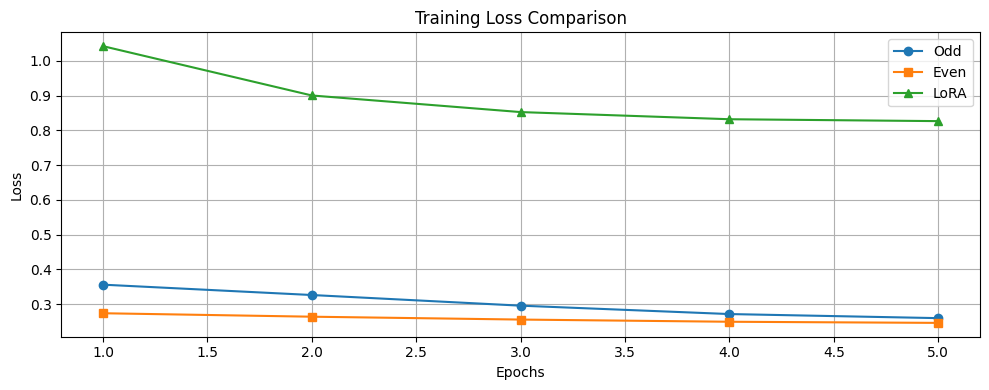

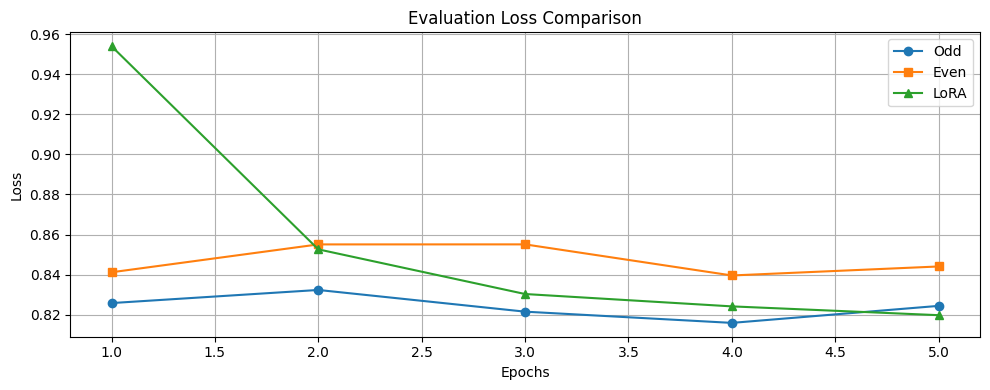

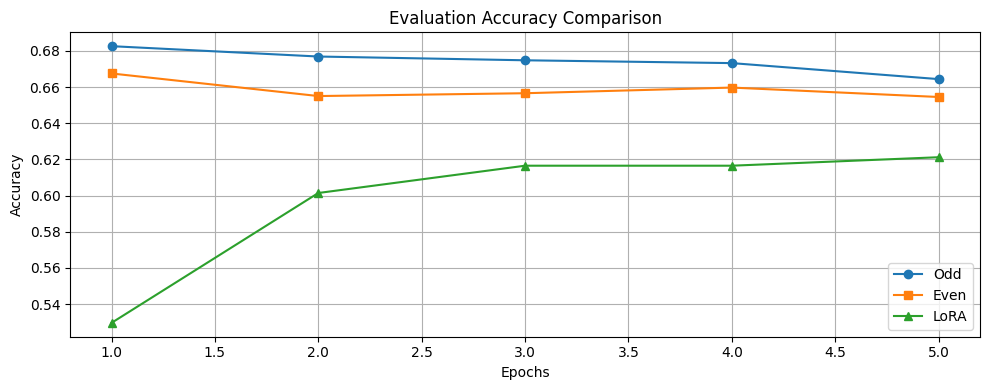

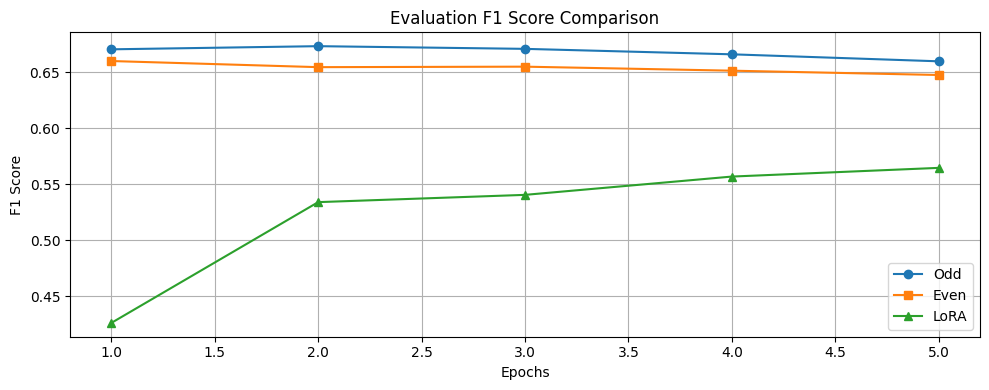

In [ ]:
import matplotlib.pyplot as plt

# Epochs list
epochs = list(range(1, len(odd_result['train_losses']) + 1))

# Accuracy
odd_acc = [m['accuracy'] for m in odd_result['metrics_per_epoch']]
even_acc = [m['accuracy'] for m in even_result['metrics_per_epoch']]
lora_acc = [m['accuracy'] for m in lora_result['metrics_per_epoch']]

# F1 Score
odd_f1 = [m['f1'] for m in odd_result['metrics_per_epoch']]
even_f1 = [m['f1'] for m in even_result['metrics_per_epoch']]
lora_f1 = [m['f1'] for m in lora_result['metrics_per_epoch']]

# Plot: Training Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_result['train_losses'], label="Odd", marker='o')
plt.plot(epochs, even_result['train_losses'], label="Even", marker='s')
plt.plot(epochs, lora_result['train_losses'], label="LoRA", marker='^')
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Evaluation Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_result['eval_losses'], label="Odd", marker='o')
plt.plot(epochs, even_result['eval_losses'], label="Even", marker='s')
plt.plot(epochs, lora_result['eval_losses'], label="LoRA", marker='^')
plt.title("Evaluation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_acc, label="Odd", marker='o')
plt.plot(epochs, even_acc, label="Even", marker='s')
plt.plot(epochs, lora_acc, label="LoRA", marker='^')
plt.title("Evaluation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: F1 Score
plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_f1, label="Odd", marker='o')
plt.plot(epochs, even_f1, label="Even", marker='s')
plt.plot(epochs, lora_f1, label="LoRA", marker='^')
plt.title("Evaluation F1 Score Comparison")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


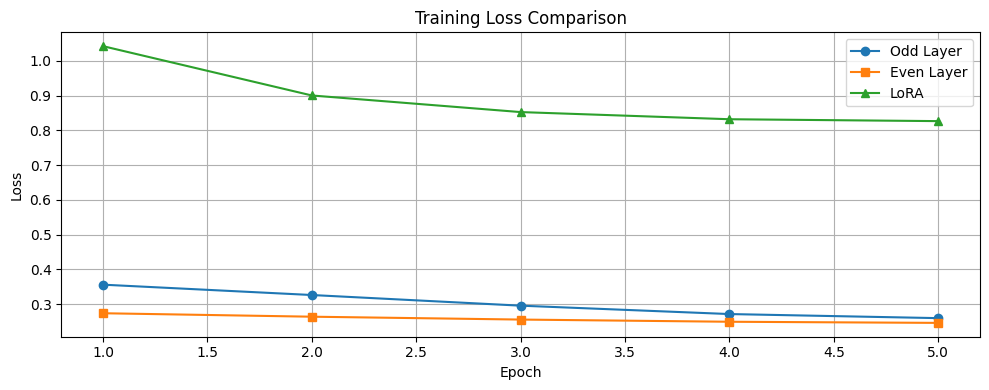

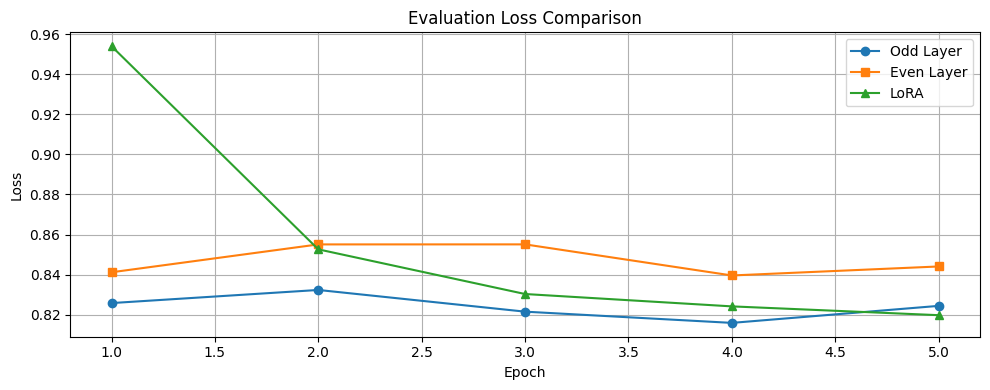

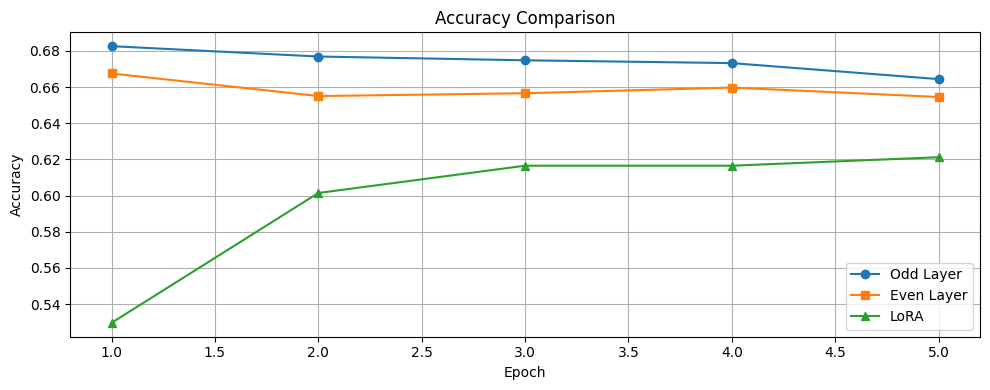

In [ ]:
import matplotlib.pyplot as plt

# 1. Extract metrics
epochs = list(range(1, num_epochs + 1))

# 📊 Accuracy
odd_acc = [m['accuracy'] for m in odd_result['metrics_per_epoch']]
even_acc = [m['accuracy'] for m in even_result['metrics_per_epoch']]
lora_acc = [m['accuracy'] for m in lora_result['metrics_per_epoch']]

# 📉 Train Loss
odd_train_loss = odd_result['train_losses']
even_train_loss = even_result['train_losses']
lora_train_loss = lora_result['train_losses']

# 📉 Eval Loss
odd_eval_loss = odd_result['eval_losses']
even_eval_loss = even_result['eval_losses']
lora_eval_loss = lora_result['eval_losses']

# ------------------------
# 2. Plot: Training Loss
# ------------------------
plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_train_loss, label="Odd Layer", marker="o")
plt.plot(epochs, even_train_loss, label="Even Layer", marker="s")
plt.plot(epochs, lora_train_loss, label="LoRA", marker="^")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------
# 3. Plot: Evaluation Loss
# ------------------------
plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_eval_loss, label="Odd Layer", marker="o")
plt.plot(epochs, even_eval_loss, label="Even Layer", marker="s")
plt.plot(epochs, lora_eval_loss, label="LoRA", marker="^")
plt.title("Evaluation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------
# 4. Plot: Evaluation Accuracy
# ------------------------
plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_acc, label="Odd Layer", marker="o")
plt.plot(epochs, even_acc, label="Even Layer", marker="s")
plt.plot(epochs, lora_acc, label="LoRA", marker="^")
plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


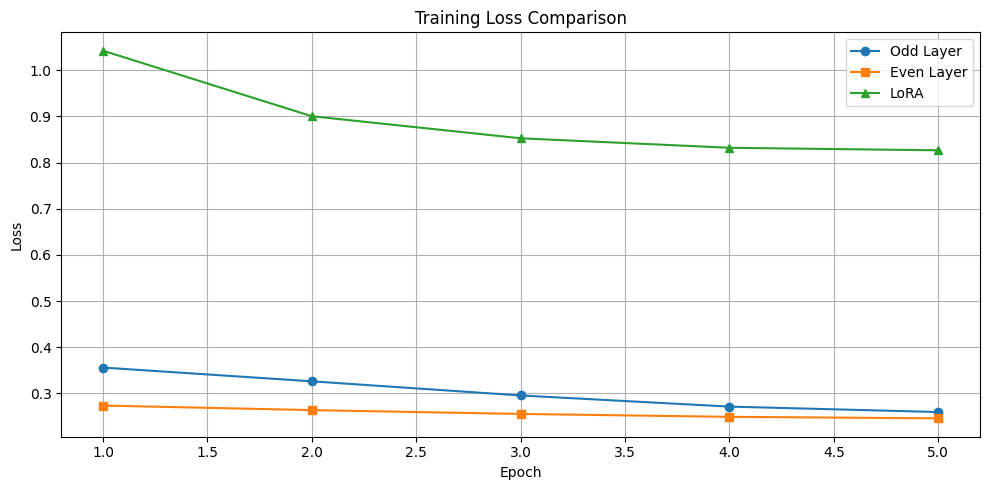

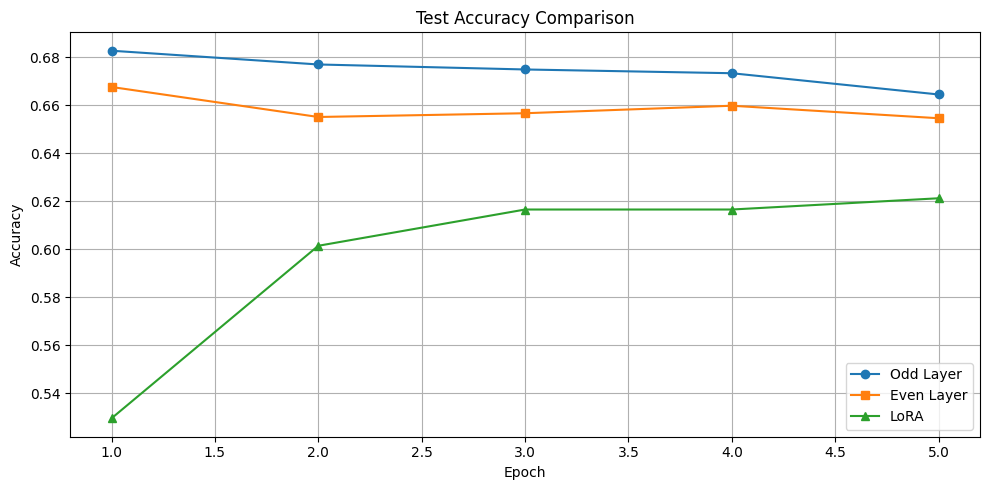

In [ ]:
import matplotlib.pyplot as plt

# Define epoch range
epochs = list(range(1, num_epochs + 1))

# 📉 Training Loss
odd_train_loss = odd_result['train_losses']
even_train_loss = even_result['train_losses']
lora_train_loss = lora_result['train_losses']

# 📊 Test Accuracy
odd_acc = [m['accuracy'] for m in odd_result['metrics_per_epoch']]
even_acc = [m['accuracy'] for m in even_result['metrics_per_epoch']]
lora_acc = [m['accuracy'] for m in lora_result['metrics_per_epoch']]

# ----------------------------------
# Plot: Training Loss Comparison
# ----------------------------------
plt.figure(figsize=(10, 5))
plt.plot(epochs, odd_train_loss, label="Odd Layer", marker="o")
plt.plot(epochs, even_train_loss, label="Even Layer", marker="s")
plt.plot(epochs, lora_train_loss, label="LoRA", marker="^")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------
# Plot: Test Accuracy Comparison
# ----------------------------------
plt.figure(figsize=(10, 5))
plt.plot(epochs, odd_acc, label="Odd Layer", marker="o")
plt.plot(epochs, even_acc, label="Even Layer", marker="s")
plt.plot(epochs, lora_acc, label="LoRA", marker="^")
plt.title("Test Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
train_losses_odd_epoch = []
train_losses_even_epoch = []
eval_losses_odd_epoch = []
eval_losses_even_epoch = []

for epoch in range(num_epochs):
    train_loss_odd_epoch = sum(train_losses_odd) / len(train_dataloader)  # Average per epoch
    train_loss_even_epoch = sum(train_losses_even) / len(train_dataloader)
    eval_loss_odd_epoch = sum(eval_losses_odd) / len(eval_dataloader)
    eval_loss_even_epoch = sum(eval_losses_even) / len(eval_dataloader)

    train_losses_odd_epoch.append(train_loss_odd_epoch)
    train_losses_even_epoch.append(train_loss_even_epoch)
    eval_losses_odd_epoch.append(eval_loss_odd_epoch)
    eval_losses_even_epoch.append(eval_loss_even_epoch)


In [ ]:
train_losses_odd_epoch = []
train_losses_even_epoch = []
eval_losses_odd_epoch = []
eval_losses_even_epoch = []

for epoch in range(num_epochs):
    train_loss_odd_epoch = sum(train_losses_odd) / len(train_dataloader)  # Average per epoch
    train_loss_even_epoch = sum(train_losses_even) / len(train_dataloader)
    eval_loss_odd_epoch = sum(eval_losses_odd) / len(eval_dataloader)
    eval_loss_even_epoch = sum(eval_losses_even) / len(eval_dataloader)

    train_losses_odd_epoch.append(train_loss_odd_epoch)
    train_losses_even_epoch.append(train_loss_even_epoch)
    eval_losses_odd_epoch.append(eval_loss_odd_epoch)
    eval_losses_even_epoch.append(eval_loss_even_epoch)


In [ ]:
import matplotlib.pyplot as plt

# Define epochs for x-axis
epochs_list = range(1, num_epochs + 1)

# Create figure
plt.figure(figsize=(12, 6))

# Plot training losses (now correctly averaged per epoch)
plt.plot(epochs_list, train_losses_odd_epoch, label='Train Loss (Odd Layers)', linestyle='-', marker='o')
plt.plot(epochs_list, train_losses_even_epoch, label='Train Loss (Even Layers)', linestyle='-', marker='s')

# Plot validation losses
plt.plot(epochs_list, eval_losses_odd_epoch, label='Validation Loss (Odd Layers)', linestyle='--', marker='o')
plt.plot(epochs_list, eval_losses_even_epoch, label='Validation Loss (Even Layers)', linestyle='--', marker='s')

# Titles and labels
plt.title('Comparison of Training and Validation Losses for Odd vs Even Layer Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses, label='Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

    # Store losses for visualization
    train_losses.append(train_loss / len(train_dataloader))
    train_losses_cls.append(train_loss_cls / len(train_dataloader))
    train_losses_div.append(train_loss_div / len(train_dataloader))
    train_losses_cos.append(train_loss_cos / len(train_dataloader))

### Appendix (Teacher Model)

In [122]:
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn

lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')

    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions,
            references=batch["labels"])

    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy']
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")

print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/9615 [00:00<?, ?it/s]

NameError: name 'lr_scheduler' is not defined